In [1]:
import torch

class LossFunction:
    def __init__(self, alpha=1.0, eps=1e-8, use_regularization=False, lam=0.001):
        """
        Initialize the loss function with given parameters.
        
        Args:
            alpha (float): Scaling parameter for edge probability.
            eps (float): Small value to prevent log(0).
            use_regularization (bool): Whether to include Gaussian regularization.
        """
        self.alpha = alpha
        self.eps = eps
        self.lam = lam
        self.use_regularization = use_regularization

    def edge_probability(self, z_i, z_j):
        """Compute the probability of an edge existing between two embeddings."""
        dist = torch.norm(z_i - z_j) ** 2  # Squared Euclidean distance
        return 1 / (1 + torch.exp(-self.alpha + dist))  # Logistic function

    def link_loss(self, label, z_u, z_v):
        """Compute the loss for a single edge."""
        prob = self.edge_probability(z_u, z_v)
        prob = torch.clamp(prob, self.eps, 1 - self.eps)  # Numerical stability

        return label.float() * torch.log(prob) + (1 - label.float()) * torch.log(1 - prob)

    def compute_loss(self, z, datamatrix_tensor):
        """Compute the total loss for the dataset."""
        sum_loss = sum(
            self.link_loss(label, z[u_idx], z[v_idx])
            for label, u_idx, v_idx in datamatrix_tensor
        )

        loss = -sum_loss / len(datamatrix_tensor)

        if self.use_regularization:
            regularization = self.lam * torch.sum(z ** 2)
            loss += regularization

        return loss
    

# loss_fn = LossFunction(alpha=1.0, use_regularization=True)
# loss_value = loss_fn.compute_loss(z, datamatrix_tensor)

In [12]:
# import torch
# import numpy as np
# import matplotlib as plt
# import seaborn as sns
# loss_fn = LossFunction(alpha=1.0, use_regularization=False)

# class Evaluator:
#     def __init__(self, all_nodes, num_nodes_set_1, emb_matrix, threshold, edges):
#         self.all_nodes = all_nodes
#         self.num_nodes_set_1 = num_nodes_set_1
#         self.emb_matrix = emb_matrix
#         self.threshold = threshold
#         self.edges = edges

#     def compute_TP_FP_TN_FN(self):
#         TP = FP = TN = FN = 0
        
#         with torch.no_grad():
#             for u in range(len(self.all_nodes)):
#                 for v in range(u + 1, len(self.all_nodes)):
#                     if (u in range(self.num_nodes_set_1) and v in range(self.num_nodes_set_1, len(self.all_nodes))) or \
#                        (v in range(self.num_nodes_set_1) and u in range(self.num_nodes_set_1, len(self.all_nodes))):
                        
#                         label = 1 if (self.all_nodes[u], self.all_nodes[v]) in self.edges or \
#                                        (self.all_nodes[v], self.all_nodes[u]) in self.edges else 0
                        
#                         u_embedding = torch.tensor(self.emb_matrix[u], dtype=torch.float32)
#                         v_embedding = torch.tensor(self.emb_matrix[v], dtype=torch.float32)
#                         prob = loss_fn.edge_probability(u_embedding, v_embedding)
                        
#                         predicted_label = 1 if prob > self.threshold else 0
                        
#                         if label == 1 and predicted_label == 1:
#                             TP += 1
#                         elif label == 0 and predicted_label == 1:
#                             FP += 1
#                         elif label == 0 and predicted_label == 0:
#                             TN += 1
#                         elif label == 1 and predicted_label == 0:
#                             FN += 1
        
#         return TP, FP, TN, FN

#     def compute_accuracy(self):
#         TP, FP, TN, FN = self.compute_TP_FP_TN_FN()
#         return (TP + TN) / (TP + TN + FP + FN) if (TP + TN + FP + FN) > 0 else 0
    
#     def compute_recall(self):
#         TP, _, _, FN = self.compute_TP_FP_TN_FN()
#         return TP / (TP + FN) if (TP + FN) > 0 else 0
    
#     def compute_precision(self):
#         TP, FP, _, _ = self.compute_TP_FP_TN_FN()
#         return TP / (TP + FP) if (TP + FP) > 0 else 0
    
#     def f1_score(self):
#         recall, precision = self.compute_recall(), self.compute_precision()
#         return 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
    
#     def plot_confusion_matrix(self):
#         TP, FP, TN, FN = self.compute_TP_FP_TN_FN()
#         conf_matrix = np.array([[TN, FP], 
#                         [FN, TP]])

#         # Plot the confusion matrix
#         plt.figure(figsize=(6, 5))
#         sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues",
#                     xticklabels=["Predicted Negative", "Predicted Positive"],
#                     yticklabels=["Actual Negative", "Actual Positive"])

#         plt.xlabel("Predicted Label")
#         plt.ylabel("Actual Label")
#         plt.title("Confusion Matrix")
#         plt.savefig("confusion_matrix.png")
#         plt.show()

True Category Assignments:
B0 -> C3
B1 -> C3
B2 -> C1
B3 -> C4
B4 -> C1
B5 -> C1
B6 -> C1
B7 -> C1
B8 -> C0
B9 -> C2
Epoch 0: Loss = 0.4446
Epoch 100: Loss = 0.0882
Epoch 200: Loss = 0.0458
Epoch 300: Loss = 0.0344
Epoch 400: Loss = 0.0303
Category Prediction Accuracy: 0.2000


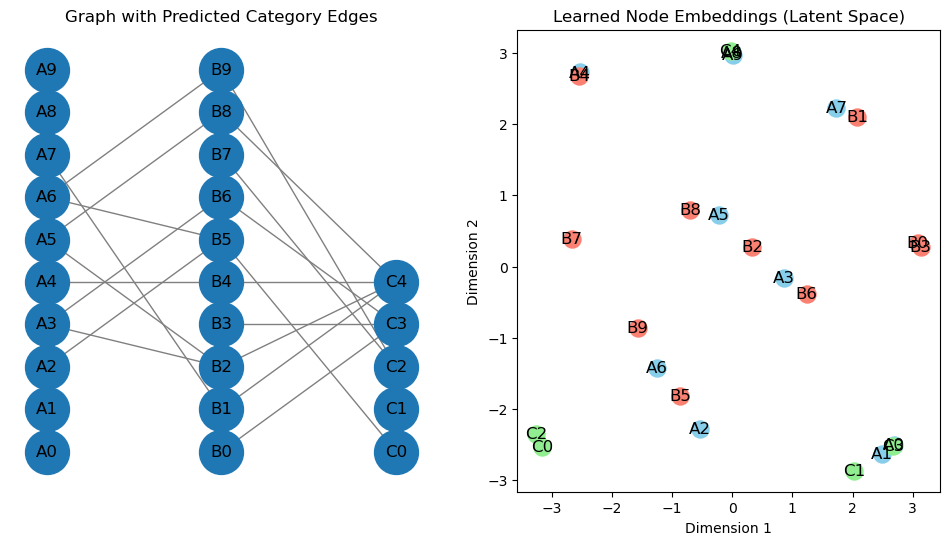

In [ ]:
import networkx as nx
import torch
import torch.nn.functional as F
import random
import matplotlib.pyplot as plt
import numpy as np

# 1️ Generate Bipartite Graph with Known Category Assignments
random.seed(99)
num_nodes_set_1 = 10  # Left column (A nodes)
num_nodes_set_2 = 10  # Middle column (B nodes)
num_nodes_set_3 = 5   # Right column (C nodes, predefined categories)

nodes_set_1 = [f"A{i}" for i in range(num_nodes_set_1)]
nodes_set_2 = [f"B{i}" for i in range(num_nodes_set_2)]
nodes_set_3 = [f"C{i}" for i in range(num_nodes_set_3)]
all_nodes = nodes_set_1 + nodes_set_2 + nodes_set_3

# # Predefine category assignments for B nodes
# true_categories = {nodes_set_2[i]: random.choice(nodes_set_3) for i in range(num_nodes_set_2)}
# print("True Category Assignments:")
# for b, c in true_categories.items():
#     print(f"{b} -> {c}")

G = nx.Graph()
G.add_nodes_from(nodes_set_1, bipartite=0)
G.add_nodes_from(nodes_set_2, bipartite=1)
G.add_nodes_from(nodes_set_3, bipartite=2)

# Add edges between A and B
edges = []
for u in nodes_set_1:
    for v in nodes_set_2:
        if random.random() > 0.9:  # 10% chance of an edge
            G.add_edge(u, v)
            edges.append((u, v))

# 2️ Create the Data Matrix (Edge / Non-Edge Pairs)
# Create the `datamatrix` for training
datamatrix = []

# Include edges between set_1 ↔ set_2 (for training)
for u in nodes_set_1:
    for v in nodes_set_2:
        label = 1 if (u, v) in edges or (v, u) in edges else 0
        u_idx = all_nodes.index(u)
        v_idx = all_nodes.index(v)
        datamatrix.append([label, u_idx, v_idx])

# Include edges between set_2 ↔ set_3 (for training)
for u in nodes_set_2:
    for v in nodes_set_3:
        label = 1 if (u, v) in edges or (v, u) in edges else 0
        u_idx = all_nodes.index(u)
        v_idx = all_nodes.index(v)
        datamatrix.append([label, u_idx, v_idx])

datamatrix = np.array(datamatrix)
datamatrix_tensor = torch.tensor(datamatrix, dtype=torch.long)

# 2️ Define Embeddings
embedding_dim = 2
node_embeddings = torch.nn.Embedding(len(all_nodes), embedding_dim)
optimizer = torch.optim.Adam(node_embeddings.parameters(), lr=0.01)

loss_function = LossFunction(alpha=1.0, eps=1e-10, use_regularization=False)

# 3️ Train Embeddings
alpha = 3
num_epochs = 500
for epoch in range(num_epochs):
    optimizer.zero_grad()
    z = node_embeddings.weight  # Get embeddings
    loss = loss_function.compute_loss(z, datamatrix_tensor)  # Compute loss
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print(f"Epoch {epoch}: Loss = {loss.item():.4f}")

# 4️ Assign B nodes to C nodes using Shortest Latent Space Distance
emb_matrix = node_embeddings.weight.detach()
# predicted_categories = {}
predicted_edges = []

# Loop over the B nodes
for b in nodes_set_2:
    b_idx = all_nodes.index(b)
    distances = []
    
    # For each C node, compute the Euclidean distance between their embeddings
    for c in nodes_set_3:
        c_idx = all_nodes.index(c)
        dist = torch.norm(emb_matrix[b_idx] - emb_matrix[c_idx])  # Euclidean distance
        distances.append((dist.item(), c))
    
    # Assign the C node with the shortest distance
    assigned_c = min(distances, key=lambda x: x[0])[1]  # Get the closest C node
    # predicted_categories[b] = assigned_c
    predicted_edges.append((b, assigned_c))
    G.add_edge(b, assigned_c)  # Add edge to graph

# # 5️ Compute Accuracy of Category Prediction
# correct = sum(1 for b in nodes_set_2 if predicted_categories[b] == true_categories[b])
# accuracy = correct / len(nodes_set_2)
# print(f"Category Prediction Accuracy: {accuracy:.4f}")

# 6️ Plot Graph with Category Labels
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
pos = {node: (0, i) for i, node in enumerate(nodes_set_1)}
pos.update({node: (1, i) for i, node in enumerate(nodes_set_2)})
pos.update({node: (2, i) for i, node in enumerate(nodes_set_3)})
nx.draw(G, pos, with_labels=True, node_size=1000, edge_color="gray", ax=axes[0])
axes[0].set_title("Graph with Predicted Category Edges")

# 7️ Plot Latent Space
emb_array = emb_matrix.numpy()
for idx, node in enumerate(all_nodes):
    color = 'skyblue' if node in nodes_set_1 else 'salmon' if node in nodes_set_2 else 'lightgreen'
    axes[1].scatter(emb_array[idx, 0], emb_array[idx, 1], c=color, s=150)
    axes[1].text(emb_array[idx, 0], emb_array[idx, 1], node, fontsize=12, ha='center', va='center')
axes[1].set_title("Learned Node Embeddings (Latent Space)")
axes[1].set_xlabel("Dimension 1")
axes[1].set_ylabel("Dimension 2")
plt.show()


In [14]:
# # Instantiate Evaluator
# threshold = 0.5  # Set threshold for classification
# evaluator = Evaluator(all_nodes, num_nodes_set_3, emb_matrix, threshold, edges)

# # Compute and print evaluation metrics
# accuracy = evaluator.compute_accuracy()
# recall = evaluator.compute_recall()
# precision = evaluator.compute_precision()
# f1 = evaluator.f1_score()

# print(f"Evaluation Metrics:")
# print(f"  Accuracy: {accuracy:.4f}")
# print(f"  Recall: {recall:.4f}")
# print(f"  Precision: {precision:.4f}")
# print(f"  F1 Score: {f1:.4f}")

# # Plot confusion matrix
# evaluator.plot_confusion_matrix()

tensor([[ 1, 25,  5],
        [ 1, 25,  6],
        [ 1, 25,  8]])
Epoch 0: Loss = 6.9265
Epoch 50: Loss = 5.1879
Epoch 100: Loss = 4.3771
Epoch 150: Loss = 4.0801
Epoch 200: Loss = 3.9840
Epoch 250: Loss = 3.9602
Epoch 300: Loss = 3.9559
Epoch 350: Loss = 3.9553
Epoch 400: Loss = 3.9552
Epoch 450: Loss = 3.9552


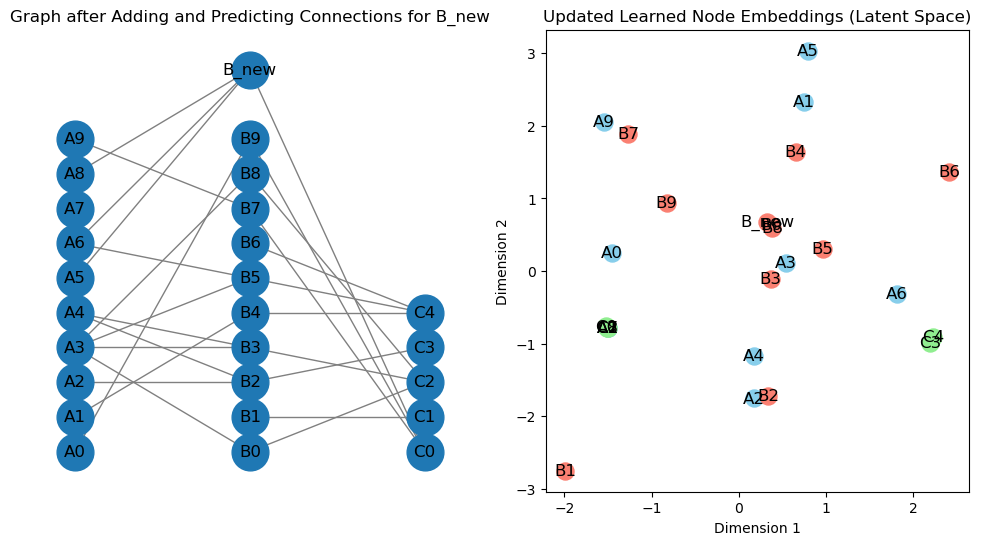

New node 'B_new' is predicted to connect with 'C0'


In [15]:
# 1️ Freeze all trained embeddings
node_embeddings.weight.requires_grad = False
emb_matrix = node_embeddings.weight.detach().clone()  # Store trained embeddings

# 2️ Add the new node to set_2
new_node = "B_new"
nodes_set_2.append(new_node)  # Add to set_2
all_nodes.append(new_node)    # Add to all nodes list

G.add_node(new_node, bipartite=1)  # Node added to set_2 (bipartite=1)

# 3️ Create embedding for B_new
new_embedding = torch.nn.Embedding(1, embedding_dim)

# 4️ Connect B_new to existing set_1 nodes (randomly)
new_edges = []
for u in nodes_set_1:
    if random.random() > 0.7:  # 50% chance of an edge
        G.add_edge(new_node, u)
        new_edges.append((new_node, u))

# 5️ Convert new edges into a training matrix
new_datamatrix = []
for u, v in new_edges:
    label = 1 if (u, v) in new_edges or (v, u) in new_edges else 0
    u_idx = all_nodes.index(u)
    v_idx = all_nodes.index(v)
    new_datamatrix.append([label, u_idx, v_idx])

new_datamatrix = torch.tensor(new_datamatrix, dtype=torch.long)

print(new_datamatrix)

# 6️ Define optimizer for ONLY the new node's embedding
optimizer = torch.optim.Adam(new_embedding.parameters(), lr=0.01)  # Optimize only B_new's embedding!

num_epochs = 500
for epoch in range(num_epochs):
    optimizer.zero_grad()

    # Get embeddings for training
    temp_embeddings = torch.cat([emb_matrix, new_embedding.weight], dim=0)  # Concatenate fixed + new embeddings to avoid retraining
    loss = loss_function.compute_loss(temp_embeddings, new_datamatrix)  # Compute loss

    loss.backward()
    optimizer.step()

    if epoch % 50 == 0:
        print(f"Epoch {epoch}: Loss = {loss.item():.4f}")

### Temporary ###

# 7️ Predict connection between B_new and set_3
new_node_idx = len(all_nodes) - 1  # Last index is the new node
distances = []

for c in nodes_set_3:
    c_idx = all_nodes.index(c)
    dist = torch.norm(new_embedding.weight - emb_matrix[c_idx])  # Euclidean distance
    distances.append((dist.item(), c))

# 8️ Assign B_new to closest C node
assigned_c = min(distances, key=lambda x: x[0])[1]
G.add_edge(new_node, assigned_c)  # Predict an edge

# 9️ Visualize Updated Graph
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
pos[new_node] = (1, len(nodes_set_2))  # Place it in set_2
nx.draw(G, pos, with_labels=True, node_size=700, edge_color="gray",ax=axes[0])
axes[0].set_title("Graph after Adding and Predicting Connections for B_new")

# 10 Plot Updated Latent Space
emb_array = torch.cat([emb_matrix, new_embedding.weight], dim=0).detach().numpy()


for idx, node in enumerate(all_nodes):
    color = 'skyblue' if node in nodes_set_1 else 'salmon' if node in nodes_set_2 else 'lightgreen'
    axes[1].scatter(emb_array[idx, 0], emb_array[idx, 1], c=color, s=150)
    axes[1].text(emb_array[idx, 0], emb_array[idx, 1], node, fontsize=12, ha='center', va='center')

axes[1].set_title("Updated Learned Node Embeddings (Latent Space)")
axes[1].set_xlabel("Dimension 1")
axes[1].set_ylabel("Dimension 2")
plt.show()

print(f"New node '{new_node}' is predicted to connect with '{assigned_c}'")
